# 2D

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
from mpi4py import MPI
import pickle


# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import *
from vmc_torch.sampler import MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SignedSGD, SignedRandomSGD, SR, TrivialPreconditioner, Adam, SGD_momentum, DecayScheduler
from vmc_torch.VMC import VMC
# from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.fermion_utils import generate_random_fpeps
from vmc_torch.utils import closest_divisible

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(4)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly-2)
# N_f=12
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice_torch(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = -1
dtype=torch.float64

# Load PEPS
try:
    skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
    peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
    peps = qtn.unpack(peps_params, skeleton)
except:
    peps = generate_random_fpeps(Lx, Ly, D=D, seed=2, symmetry=symmetry, Nf=N_f, spinless=False)[0]
peps_np = peps.copy()
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))

# VMC sample size
N_samples = 2
N_samples = closest_divisible(N_samples, SIZE)

model = fTNModel_reuse(peps, max_bond=chi)
model.apply(lambda x: init_weights_to_zero(x, std=2e-2))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
nn_hidden_dim = 4
model_names = {
    fTNModel: 'fTN',
    fTN_backflow_Model: 'fTN_backflow',
    fTN_backflow_Model_embedding: 'fTN_backflow_embedding',
    fTN_backflow_attn_Model: f'fTN_backflow_attn_Nh={nn_hidden_dim}',
    fTN_backflow_attn_Jastrow_Model: 'fTN_backflow_attn_Jastrow',
    fTN_backflow_attn_Model_boundary: 'fTN_backflow_attn_boundary',
    fTN_backflow_Model_Blockwise: 'fTN_backflow_blockwise',
    PureAttention_Model: 'PureAttention',
    SlaterDeterminant: 'SlaterDeterminant',
    NeuralBackflow: 'NeuralBackflow',
    NeuralBackflow_spinful: 'NeuralBackflow_spinful',
    HFDS: 'HFDS',
    FFNN: 'FFNN',
    NNBF: 'NNBF',
    NeuralJastrow: 'NeuralJastrow',
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
total_steps = 200
if init_step != 0:
    saved_model_params = torch.load(f'../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
optimizer = SGD(learning_rate=0.05)
sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=2, reset_chain=False, random_edge=False, equal_partition=True, dtype=dtype)
# sampler = None
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# preconditioner = TrivialPreconditioner()
vmc = VMC(H, variational_state=variational_state, optimizer=optimizer, preconditioner=preconditioner)

/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:271: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos1 = FermionicOperator(new_oddpos, dual=True) if new_oddpos is not () else ()
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:272: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos = ftsdata.oddpos + (new_oddpos1,) if new_oddpos1 is not () else ftsdata.oddpos
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:383: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos = ftsdata.oddpos + (new_oddpos1,) if new_oddpos1 is not () else ftsdata.oddpos
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment/vmc_torch/fermion_utils.py:860: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  new_oddpos1 = FermionicOperator(new_oddpos, dual=True) if new_oddpos is not () else ()
/global/u1/s/sijingdu/VMC/fermion/vmc_torch_experiment

In [2]:
random_config = torch.tensor(H.hilbert.random_state())
model.get_local_amp_tensors([0,1,2], random_config)

PEPS(tensors=3, indices=6, Lx=4, Ly=4, max_bond=4)

In [4]:
from vmc_torch.experiment.tn_model import *
class fTNModel_reuse(wavefunctionModel):
    def __init__(self, ftn, max_bond=None, dtype=torch.float32, functional=False):
        super().__init__()
        self.param_dtype = dtype
        self.functional = functional
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(ftn)

        # Flatten the dictionary structure and assign each parameter as a part of a ModuleDict
        self.torch_tn_params = nn.ModuleDict({
            str(tid): nn.ParameterDict({
                str(sector): nn.Parameter(data)
                for sector, data in blk_array.items()
            })
            for tid, blk_array in params.items()
        })

        # Get symmetry
        self.symmetry = ftn.arrays[0].symmetry

        # Store the shapes of the parameters
        self.param_shapes = [param.shape for param in self.parameters()]

        self.model_structure = {
            f'fPEPS (chi={max_bond})':{'D': ftn.max_bond(), 'Lx': ftn.Lx, 'Ly': ftn.Ly, 'symmetry': self.symmetry},
        }
        if max_bond is None or max_bond <= 0:
            max_bond = None
        self.max_bond = max_bond
        self.tree = None
        self.Lx = ftn.Lx
        self.Ly = ftn.Ly
    
    def from_1d_to_2d(self, config, ordering='snake'):
        if ordering == 'snake':
            config_2d = config.reshape((self.Lx, self.Ly))
        return config_2d
    
    def transform_quimb_env_x_key_to_config_key(self, env_x, config):
        """
            Return a dictionary with the keys of of the config rows
        """
        config_2d = self.from_1d_to_2d(config)
        env_x_row_config = {}
        for key in env_x.keys():
            if key[0] == 'xmax': # from bottom to top
                row_n = key[1]
                if row_n != self.Lx-1:
                    rows_config = tuple(torch.cat(tuple(config_2d[row_n+1:].to(torch.int))).tolist())
                    env_x_row_config[('xmax', rows_config)] = env_x[key]
            elif key[0] == 'xmin': # from top to bottom
                row_n = key[1]
                if row_n != 0:
                    rows_config = tuple(torch.cat(tuple(config_2d[:row_n].to(torch.int))).tolist())
                    env_x_row_config[('xmin', rows_config)] = env_x[key]
                    
        return env_x_row_config

    def cache_env_x(self, amp, config):
        """
            Cache the environment x for the given configuration
        """
        env_x = amp.compute_x_environments(max_bond=self.max_bond, cutoff=0.0)
        env_x_cache = self.transform_quimb_env_x_key_to_config_key(env_x, config)
        self._env_x_cache = env_x_cache
    
    def cache_env_y(self, amp, config):
        ...
    
    def cache_env(self, amp, config):
        """
            Cache the environment x and y for the given configuration
        """
        self.cache_env_x(amp, config)
        self.cache_env_y(amp, config)
        
    @property
    def env_x_cache(self):
        """
            Return the cached environment x
        """
        if hasattr(self, '_env_x_cache'):
            return self._env_x_cache
        else:
            return None
        
    @property
    def env_y_cache(self):
        """
            Return the cached environment y
        """
        if hasattr(self, '_env_y_cache'):
            return self._env_y_cache
        else:
            return None
    
    def clear_env_x_cache(self):
        """
            Clear the cached environment x
        """
        if hasattr(self, '_env_cache_x'):
            del self._env_x_cache

    def clear_env_y_cache(self):
        """
            Clear the cached environment y
        """
        if hasattr(self, '_env_cache_y'):
            del self._env_y_cache
    
    def clear_wavefunction_env_cache(self):
        self.clear_env_x_cache()
        self.clear_env_y_cache()
    
    def detect_changed_rows(self, config_ref, new_config):
        """
            Detect the rows that have changed in the new configuration
        """
        config_ref_2d = self.from_1d_to_2d(config_ref)
        new_config_2d = self.from_1d_to_2d(new_config)
        changed_rows = []
        for i in range(self.Lx):
            if not torch.equal(config_ref_2d[i], new_config_2d[i]):
                changed_rows.append(i)
        unchanged_rows_above = list(range(changed_rows[0]))
        unchanged_rows_below = list(range(changed_rows[-1]+1, self.Lx))
        return changed_rows, unchanged_rows_above, unchanged_rows_below
        
    
    def amplitude(self, x):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {
            int(tid): {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in self.torch_tn_params.items()
        }
        # Reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
        # `x` is expected to be batched as (batch_size, input_dim)
        # Loop through the batch and compute amplitude for each sample
        batch_amps = []
        for x_i in x:
            # Check x_i type
            if not type(x_i) == torch.Tensor:
                x_i = torch.tensor(x_i, dtype=torch.int if self.functional else self.param_dtype)
            else:
                if x_i.dtype != self.param_dtype:
                    x_i = x_i.to(torch.int if self.functional else self.param_dtype)
            # Get the amplitude
            amp = psi.get_amp(x_i, conj=True, functional=self.functional)

            if self.max_bond is None:
                amp = amp
                if self.tree is None:
                    opt = ctg.HyperOptimizer(progbar=True, max_repeats=10, parallel=True)
                    self.tree = amp.contraction_tree(optimize=opt)
                amp_val = amp.contract(optimize=self.tree)

            else:
                if self.cache_env_mode:
                    assert self.env_x_cache is None
                    self.cache_env_x(amp, x_i)
                    self.config_ref = x_i
                    config_2d = self.from_1d_to_2d(x_i)
                    key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[self.Lx//2:].to(torch.int))).tolist()))
                    key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:self.Lx//2].to(torch.int))).tolist()))
                    amp_bot = self.env_x_cache[key_bot]
                    amp_top = self.env_x_cache[key_top]
                    amp_val = (amp_bot|amp_top).contract()
                
                else:
                    if self.env_x_cache is None:
                        # check whether we can reuse the cached environment
                        amp = amp.contract_boundary_from_ymin(max_bond=self.max_bond, cutoff=0.0, yrange=[0, psi.Ly//2-1])
                        amp = amp.contract_boundary_from_ymax(max_bond=self.max_bond, cutoff=0.0, yrange=[psi.Ly//2, psi.Ly-1])
                        amp_val = amp.contract()
                    else:
                        config_2d = self.from_1d_to_2d(x_i)
                        # detect the rows that have changed
                        changed_rows, unchanged_rows_above, unchanged_rows_below = self.detect_changed_rows(self.config_ref, x_i)
                        # for bottom envs, until the last row in the changed rows, we can reuse the env
                        # for top envs, until the first row in the changed rows, we can reuse the env
                        amp_changed_rows = qtn.TensorNetwork([amp.select(amp.x_tag_id.format(row_n)) for row_n in changed_rows])
                        amp_unchanged_bottom_env = qtn.TensorNetwork()
                        amp_unchanged_top_env = qtn.TensorNetwork()
                        if len(unchanged_rows_below):
                            amp_unchanged_bottom_env = self.env_x_cache[('xmax', tuple(torch.cat(tuple(config_2d[unchanged_rows_below].to(torch.int))).tolist()))]
                        if len(unchanged_rows_above):
                            amp_unchanged_top_env = self.env_x_cache[('xmin', tuple(torch.cat(tuple(config_2d[unchanged_rows_above].to(torch.int))).tolist()))]
                        
                        amp_val = (amp_unchanged_bottom_env|amp_unchanged_top_env|amp_changed_rows).contract()

            if amp_val==0.0:
                amp_val = torch.tensor(0.0)
            batch_amps.append(amp_val)

        # Return the batch of amplitudes stacked as a tensor
        return torch.stack(batch_amps)

In [5]:
from vmc_torch.experiment.tn_model import fTN_backflow_attn_Tensorwise_Model_v1
model = fTN_backflow_attn_Tensorwise_Model_v1(peps, max_bond=-1, embedding_dim=16, attention_heads=4, nn_final_dim=int(4), nn_eta=1.0, dtype=dtype)
model1 = fTNModel(peps, max_bond=-1)
model2 = fTN_backflow_attn_Model(peps, max_bond=-1, embedding_dim=16, attention_heads=4, nn_hidden_dim=int(Lx*Ly), nn_eta=1.0, dtype=dtype)
model3 = fTNModel_reuse(peps, max_bond=16, dtype=dtype)
model.apply(lambda x: init_weights_uniform(x, a=-5e-3, b=5e-3))
model1.apply(lambda x: init_weights_uniform(x, a=-5e-3, b=5e-3))

model.num_params, model1.num_params, model2.num_params

(36816, 3200, 62880)

In [6]:
random_config = H.hilbert.random_state()
random_config = torch.tensor(random_config, dtype=dtype)
model1(random_config), model3(random_config)

/home/sijingdu/TNVMC/VMC_code/mpsds/mpsds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
F=4.76 C=5.57 S=10.00 P=11.43: 100%|██████████| 10/10 [00:00<00:00, 344.46it/s]


(tensor([-24700.8947], dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor([-24700.8947], dtype=torch.float64, grad_fn=<StackBackward0>))

In [7]:
def from_1d_to_2d(config, Lx, Ly, ordering='snake'):
    if ordering == 'snake':
        config_2d = config.reshape((Lx, Ly))
    return config_2d

def transform_quimb_env_x_key_to_config_key(env_x, config, Lx, Ly):
    """
        Return a dictionary with the keys of of the config rows
    """
    config_2d = from_1d_to_2d(config, Lx, Ly)
    env_x_row_config = {}
    for key in env_x.keys():
        if key[0] == 'xmax': # from bottom to top
            row_n = key[1]
            if row_n != Lx-1:
                rows_config = tuple(torch.cat(tuple(config_2d[row_n+1:].to(torch.int))).tolist())
                env_x_row_config[('xmax', rows_config)] = env_x[key]
        elif key[0] == 'xmin': # from top to bottom
            row_n = key[1]
            if row_n != 0:
                rows_config = tuple(torch.cat(tuple(config_2d[:row_n].to(torch.int))).tolist())
                env_x_row_config[('xmin', rows_config)] = env_x[key]
                
    return env_x_row_config

def detect_changed_rows(config_ref, new_config, Lx, Ly):
    """
        Detect the rows that have changed in the new configuration
    """
    config_ref_2d = from_1d_to_2d(config_ref, Lx, Ly)
    new_config_2d = from_1d_to_2d(new_config, Lx, Ly)
    changed_rows = []
    for i in range(Lx):
        if not torch.equal(config_ref_2d[i], new_config_2d[i]):
            changed_rows.append(i)
    unchanged_rows_above = list(range(changed_rows[0]))
    unchanged_rows_below = list(range(changed_rows[-1]+1, Lx))
    return changed_rows, unchanged_rows_above, unchanged_rows_below

def cache_env_x(amp, config, Lx, Ly, max_bond=16):
    """
        Cache the environment x for the given configuration
    """
    env_x = amp.compute_x_environments(max_bond=max_bond, cutoff=0.0)
    env_cache = transform_quimb_env_x_key_to_config_key(env_x, config, Lx, Ly)
    return env_cache



amp0 = peps.get_amp(random_config)
env_x = amp0.compute_x_environments(max_bond=16, cutoff=0.0)
env_x_cache = transform_quimb_env_x_key_to_config_key(env_x, random_config, Lx, Ly)
(env_x[('xmax', 0)]|env_x[('xmin', 1)]).contract(), amp0.contract()

random_config_2d = from_1d_to_2d(random_config, Lx, Ly)
random_config1 = random_config.clone()
random_config1[0] = 1
random_config1[4] = 1

amp1 = peps.get_amp(random_config1)

changed_rows, unchanged_rows_above, unchanged_rows_below = detect_changed_rows(random_config, random_config1, Lx, Ly)

amp_changed_rows = qtn.TensorNetwork([amp1.select(amp0.x_tag_id.format(row_n)) for row_n in changed_rows])
amp_unchanged_bottom_env = qtn.TensorNetwork()
amp_unchanged_top_env = qtn.TensorNetwork()
if len(unchanged_rows_below):
    amp_unchanged_bottom_env = env_x_cache[('xmax', tuple(torch.cat(tuple(random_config_2d[unchanged_rows_below].to(torch.int))).tolist()))]
if len(unchanged_rows_above):
    amp_unchanged_top_env = env_x_cache[('xmin', tuple(torch.cat(tuple(random_config_2d[unchanged_rows_above].to(torch.int))).tolist()))]

amp1_approx = amp_changed_rows|amp_unchanged_bottom_env|amp_unchanged_top_env

amp1.contract(), amp1_approx.contract()

(tensor(19527.6268, dtype=torch.float64),
 tensor(19527.6268, dtype=torch.float64))

In [14]:
# amp0.compute_xmax_environments()
Lx, Ly = 6,6
rpeps = qtn.PEPS.rand(Lx, Ly, 2)
rpeps_env = rpeps.compute_x_environments(max_bond=16, cutoff=0.0)
rpeps_env

{('xmax', 5): TensorNetwork(tensors=0, indices=0),
 ('xmax', 4): PEPS(tensors=6, indices=17, Lx=6, Ly=6, max_bond=2),
 ('xmax', 3): PEPS(tensors=6, indices=23, Lx=6, Ly=6, max_bond=4),
 ('xmax', 2): PEPS(tensors=6, indices=29, Lx=6, Ly=6, max_bond=8),
 ('xmax', 1): PEPS(tensors=6, indices=35, Lx=6, Ly=6, max_bond=16),
 ('xmax', 0): PEPS(tensors=6, indices=41, Lx=6, Ly=6, max_bond=16),
 ('xmin', 0): TensorNetwork(tensors=0, indices=0),
 ('xmin', 1): PEPS(tensors=6, indices=17, Lx=6, Ly=6, max_bond=2),
 ('xmin', 2): PEPS(tensors=6, indices=23, Lx=6, Ly=6, max_bond=4),
 ('xmin', 3): PEPS(tensors=6, indices=29, Lx=6, Ly=6, max_bond=8),
 ('xmin', 4): PEPS(tensors=6, indices=35, Lx=6, Ly=6, max_bond=16),
 ('xmin', 5): PEPS(tensors=6, indices=41, Lx=6, Ly=6, max_bond=16)}

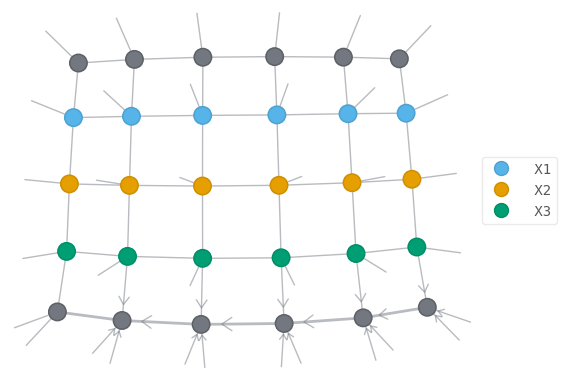

2


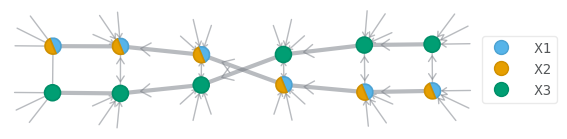

In [23]:
effected_rows = [1,2,3]
xtag_list = [rpeps.x_tag_id.format(row_n) for row_n in effected_rows]
row_ = rpeps.select(xtag_list, which='any')
top_env = qtn.TensorNetwork()
bottom_env = qtn.TensorNetwork()
top_env = rpeps_env[('xmin', min(effected_rows))]
bottom_env = rpeps_env[('xmax', max(effected_rows))]

final_tn = (row_|top_env|bottom_env)
final_tn.draw(['X1','X2','X3'])
total_rows = len(effected_rows)+2
print(effected_rows[0] + (effected_rows[-1]-effected_rows[0])//2)
final_tn.contract_boundary_from_xmin_(max_bond=16, cutoff=0.0, xrange=[0,effected_rows[0] + (effected_rows[-1]-effected_rows[0])//2])
final_tn.contract_boundary_from_xmax_(max_bond=16, cutoff=0.0, xrange=[effected_rows[-1] - (effected_rows[-1]-effected_rows[0])//2+1, Lx-1])
final_tn.draw(['X1','X2','X3'])
# final_tn

In [25]:
(row_|top_env|bottom_env)

TensorNetwork2D(tensors=30, indices=85, Lx=6, Ly=6, max_bond=4)

In [10]:
rpeps_env[('xmax', 1)]

PEPS(tensors=6, indices=35, Lx=6, Ly=6, max_bond=16)

In [97]:
random_config_2d[Lx//2:], random_config_2d[:Lx//2], random_config_2d

(tensor([[0., 3., 0., 2.],
         [2., 1., 1., 0.]], dtype=torch.float64),
 tensor([[2., 3., 1., 0.],
         [0., 0., 3., 3.]], dtype=torch.float64),
 tensor([[2., 3., 1., 0.],
         [0., 0., 3., 3.],
         [0., 3., 0., 2.],
         [2., 1., 1., 0.]], dtype=torch.float64))

In [98]:
model3.cache_env_mode = True
model3(random_config)
model3.cache_env_mode = False
model3(random_config1)

tensor([0.])

In [99]:
import numpy
env_bot = env_x_cache[('xmax', tuple(torch.cat(tuple(random_config_2d[Lx//2:].to(torch.int))).tolist()))]
env_top = env_x_cache[('xmin', tuple(torch.cat(tuple(random_config_2d[:Lx//2].to(torch.int))).tolist()))]

(env_bot|env_top).contract(), amp0.contract()

(tensor(4285.9471, dtype=torch.float64),
 tensor(4285.9471, dtype=torch.float64))

In [2]:
from vmc_torch.experiment.tn_model import *
r = 1
def get_receptive_field_2d(Lx, Ly, r, site_index_map=lambda i, j, Lx, Ly: i * Ly + j):
    """
        Get the receptive field (OBC) for each site in a square lattice graph.
        Default ordering is zig-zag ordering.
    """
    receptive_field = {}
    for i in range(Lx):
        for j in range(Ly):
            for ix in range(-r+i, r+1+i):
                for jx in range(-r+j, r+1+j):
                    if ix >= 0 and ix < Lx and jx >= 0 and jx < Ly:
                        site_id = site_index_map(i, j, Lx, Ly)
                        if site_id not in receptive_field:
                            receptive_field[site_id] = []
                        receptive_field[site_id].append(site_index_map(ix, jx, Lx, Ly))
    return receptive_field

class fTN_BFA_cluster_Model_reuse(wavefunctionModel):
    """
        fPEPS + tensorwise attention backflow NN with finite receptive field
    """
    def __init__(self, fpeps, max_bond=None, embedding_dim=32, attention_heads=4, nn_final_dim=4, nn_eta=1.0, radius=1, jastrow=False, dtype=torch.float32, debug=False):
        super().__init__()
        self.param_dtype = dtype
        self.debug = debug
        
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(fpeps)
        self.skeleton.exponent = 0

        # Flatten the dictionary structure and assign each parameter as a part of a ModuleDict
        self.torch_tn_params = nn.ModuleDict({
            str(tid): nn.ParameterDict({
                str(sector): nn.Parameter(data)
                for sector, data in blk_array.items()
            })
            for tid, blk_array in params.items()
        })

        # Get the receptive field for each site
        self.nn_radius = radius
        self.receptive_field = get_receptive_field_2d(fpeps.Lx, fpeps.Ly, self.nn_radius)

        phys_dim = fpeps.phys_dim()
        # for each tensor (labelled by tid), assign a attention+MLP
        self.nn = nn.ModuleDict()
        for tid in self.torch_tn_params.keys():
            # get the receptive field for the current tensor
            neighbors = self.receptive_field[int(tid)]
            input_dim = len(neighbors)
            on_site_ts_params_dict ={
                tid: params[int(tid)]
            }
            on_site_ts_params_vec = flatten_tn_params(on_site_ts_params_dict)
            self.nn[tid] = SelfAttn_FFNN_block(
                n_site=input_dim,
                num_classes=phys_dim,
                embedding_dim=embedding_dim,
                attention_heads=attention_heads,
                nn_hidden_dim=nn_final_dim,
                output_dim=on_site_ts_params_vec.numel(),
                dtype=self.param_dtype
            )
        if jastrow:
            global_jastrow_input_dim = fpeps.Lx * fpeps.Ly
            self.jastrow = SelfAttn_FFNN_block(
                    n_site=global_jastrow_input_dim,
                    num_classes=phys_dim,
                    embedding_dim=embedding_dim,
                    attention_heads=attention_heads,
                    nn_hidden_dim=nn_final_dim,
                    output_dim=1,
                    dtype=self.param_dtype
                )
        else:
            self.jastrow = lambda x: torch.zeros(1)

        # Get symmetry
        self.symmetry = fpeps.arrays[0].symmetry

        # Store the shapes of the parameters
        self.param_shapes = [param.shape for param in self.parameters()]

        self.model_structure = {
            'fPEPS_BFA_cluster':
            {
                'D': fpeps.max_bond(), 
                'Lx': fpeps.Lx, 'Ly': fpeps.Ly, 
                'radius': self.nn_radius,
                'jastrow': jastrow,
                'symmetry': self.symmetry, 
                'nn_final_dim': nn_final_dim,
                'nn_eta': nn_eta, 
                'embedding_dim': embedding_dim,
                'attention_heads': attention_heads,
                'max_bond': max_bond,
            },
        }
        if max_bond is None or max_bond <= 0:
            max_bond = None
        self.max_bond = max_bond
        self.nn_eta = nn_eta
        self.tree = None
        self.Lx = fpeps.Lx
        self.Ly = fpeps.Ly
        self._env_x_cache = None
        self._env_y_cache = None
        self.config_ref = None
    
    def from_1d_to_2d(self, config, ordering='snake'):
        if ordering == 'snake':
            config_2d = config.reshape((self.Lx, self.Ly))
        return config_2d
    
    def transform_quimb_env_x_key_to_config_key(self, env_x, config):
        """
            Return a dictionary with the keys of of the config rows
        """
        config_2d = self.from_1d_to_2d(config)
        env_x_row_config = {}
        for key in env_x.keys():
            if key[0] == 'xmax': # from bottom to top
                row_n = key[1]
                if row_n != self.Lx-1:
                    rows_config = tuple(torch.cat(tuple(config_2d[row_n+1:].to(torch.int))).tolist())
                    env_x_row_config[('xmax', rows_config)] = env_x[key]
            elif key[0] == 'xmin': # from top to bottom
                row_n = key[1]
                if row_n != 0:
                    rows_config = tuple(torch.cat(tuple(config_2d[:row_n].to(torch.int))).tolist())
                    env_x_row_config[('xmin', rows_config)] = env_x[key]
        return env_x_row_config
    
    def transform_quimb_env_y_key_to_config_key(self, env_y, config):
        """
            Return a dictionary with the keys of of the config rows
        """
        config_2d = self.from_1d_to_2d(config)
        env_y_row_config = {}
        for key in env_y.keys():
            if key[0] == 'ymax':
                col_n = key[1]
                if col_n != self.Ly-1:
                    cols_config = tuple(torch.cat(tuple(config_2d[:, col_n+1:].to(torch.int))).tolist())
                    env_y_row_config[('ymax', cols_config)] = env_y[key]
            elif key[0] == 'ymin':
                col_n = key[1]
                if col_n != 0:
                    cols_config = tuple(torch.cat(tuple(config_2d[:, :col_n].to(torch.int))).tolist())
                    env_y_row_config[('ymin', cols_config)] = env_y[key]
        return env_y_row_config

    def cache_env_x(self, amp, config):
        """
            Cache the environment x for the given configuration
        """
        env_x = amp.compute_x_environments(max_bond=self.max_bond, cutoff=0.0)
        env_x_cache = self.transform_quimb_env_x_key_to_config_key(env_x, config)
        self._env_x_cache = env_x_cache
        self.config_ref = config
    
    def cache_env_y(self, amp, config):
        env_y = amp.compute_y_environments(max_bond=self.max_bond, cutoff=0.0)
        env_y_cache = self.transform_quimb_env_y_key_to_config_key(env_y, config)
        self._env_y_cache = env_y_cache
        self.config_ref = config
    
    def cache_env(self, amp, config):
        """
            Cache the environment x and y for the given configuration
        """
        self.cache_env_x(amp, config)
        self.cache_env_y(amp, config)
        
    @property
    def env_x_cache(self):
        """
            Return the cached environment x
        """
        if hasattr(self, '_env_x_cache'):
            return self._env_x_cache
        else:
            return None
        
    @property
    def env_y_cache(self):
        """
            Return the cached environment y
        """
        if hasattr(self, '_env_y_cache'):
            return self._env_y_cache
        else:
            return None
    
    def clear_env_x_cache(self):
        """
            Clear the cached environment x
        """
        self._env_x_cache = None

    def clear_env_y_cache(self):
        """
            Clear the cached environment y
        """
        self._env_y_cache = None
    
    def clear_wavefunction_env_cache(self):
        self.clear_env_x_cache()
        self.clear_env_y_cache()
    
    def detect_effected_rows(self, config_ref, new_config):
        """
            Detect the rows that have been effected in the new configuration
        """
        config_ref_2d = self.from_1d_to_2d(config_ref)
        new_config_2d = self.from_1d_to_2d(new_config)
        effected_rows = set()
        for i in range(self.Lx):
            if not torch.equal(config_ref_2d[i], new_config_2d[i]):
                effected_row_top = i-self.nn_radius if i-self.nn_radius >= 0 else 0
                effected_row_bottom = i+self.nn_radius if i+self.nn_radius < self.Lx else self.Lx-1
                effected_rows.update(list(range(effected_row_top, effected_row_bottom+1)))
        effected_rows = sorted(effected_rows)

        if len(effected_rows) == 0:
            return [], [], []
        uneffected_rows_above = list(range(effected_rows[0]))
        uneffected_rows_below = list(range(effected_rows[-1]+1, self.Lx))
        return effected_rows, uneffected_rows_above, uneffected_rows_below
    
    def detect_effected_cols(self, config_ref, new_config):
        """
            Detect the cols that have been effected in the new configuration
        """
        config_ref_2d = self.from_1d_to_2d(config_ref)
        new_config_2d = self.from_1d_to_2d(new_config)
        effected_cols = set()
        for j in range(self.Ly):
            if not torch.equal(config_ref_2d[:, j], new_config_2d[:, j]):
                effected_col_left = j-self.nn_radius if j-self.nn_radius >= 0 else 0
                effected_col_right = j+self.nn_radius if j+self.nn_radius < self.Ly else self.Ly-1
                effected_cols.update(list(range(effected_col_left, effected_col_right+1)))
        effected_cols = sorted(effected_cols)

        if len(effected_cols) == 0:
            return [], [], []
        uneffected_cols_left = list(range(effected_cols[0]))
        uneffected_cols_right = list(range(effected_cols[-1]+1, self.Ly))
        return effected_cols, uneffected_cols_left, uneffected_cols_right
    
    def detect_changed_rows(self, config_ref, new_config):
        """
            Detect the rows that have changed in the new configuration
        """
        config_ref_2d = self.from_1d_to_2d(config_ref)
        new_config_2d = self.from_1d_to_2d(new_config)
        changed_rows = []
        for i in range(self.Lx):
            if not torch.equal(config_ref_2d[i], new_config_2d[i]):
                changed_rows.append(i)
        if len(changed_rows) == 0:
            return [], [], []
        unchanged_rows_above = list(range(changed_rows[0]))
        unchanged_rows_below = list(range(changed_rows[-1]+1, self.Lx))
        return changed_rows, unchanged_rows_above, unchanged_rows_below
    
    def detect_changed_cols(self, config_ref, new_config):
        """
            Detect the columns that have changed in the new configuration
        """
        config_ref_2d = self.from_1d_to_2d(config_ref)
        new_config_2d = self.from_1d_to_2d(new_config)
        changed_cols = []
        for i in range(self.Ly):
            if not torch.equal(config_ref_2d[:, i], new_config_2d[:, i]):
                changed_cols.append(i)
        if len(changed_cols) == 0:
            return [], [], []
        unchanged_cols_left = list(range(changed_cols[0]))
        unchanged_cols_right = list(range(changed_cols[-1]+1, self.Ly))
        return changed_cols, unchanged_cols_left, unchanged_cols_right
    
    def update_env_x_cache(self, config):
        """
            Update the cached environment x for the given configuration
        """
        if self.env_x_cache is not None:
            self.clear_env_x_cache()
        amp_tn = self.get_amp_tn(config)
        self.cache_env_x(amp_tn, config)
        self.config_ref = config
    
    def update_env_x_cache_to_row(self, config, row_id, from_which='xmin'):
        config_2d = self.from_1d_to_2d(config)
        amp_tn = self.get_amp_tn(config)
        upper_effected_row_id = row_id - self.nn_radius if row_id - self.nn_radius >= 0 else 0
        lower_effected_row_id = row_id + self.nn_radius if row_id + self.nn_radius < self.Lx else self.Lx-1
        row_id = upper_effected_row_id if from_which == 'xmin' else lower_effected_row_id
        # select the row_tn in the amp_tn that corresponds to the row_id
        row_tn = amp_tn.select(amp_tn.x_tag_id.format(row_id))
        if from_which == 'xmin':
            # check the whether previous env_x cache already contains the env w.r.t. row with id upper_effected_row_id
            key_prev_rows = ('xmin', tuple(torch.cat(tuple(config_2d[:row_id].to(torch.int))).tolist())) if row_id != 0 else ()
            new_env_key = ('xmin', tuple(torch.cat(tuple(config_2d[:row_id+1].to(torch.int))).tolist()))
            xrange = (0, row_id)
        elif from_which == 'xmax':
            # check the whether previous env_x cache already contains the env w.r.t. row with id lower_effected_row_id
            key_prev_rows = ('xmax', tuple(torch.cat(tuple(config_2d[row_id+1:].to(torch.int))).tolist())) if row_id != self.Lx-1 else ()
            new_env_key = ('xmax', tuple(torch.cat(tuple(config_2d[row_id:].to(torch.int))).tolist()))
            xrange = (row_id, self.Lx-1)
        else:
            raise ValueError("from_which must be either 'xmin' or 'xmax'")

        if self.env_x_cache is not None: 
            if key_prev_rows in self.env_x_cache:
                prev_env_x = self.env_x_cache[key_prev_rows]
                new_env_tn = prev_env_x | row_tn
                new_env_tn.contract_boundary_from_(max_bond=self.max_bond, cutoff=0.0, xrange=xrange, from_which=from_which, yrange=(0, self.Ly-1))
                new_env_x_cache = {new_env_key: new_env_tn}
            else:
                new_env_x = amp_tn.compute_environments(max_bond=self.max_bond, cutoff=0.0, xrange=(0, row_id+1) if from_which=='xmin' else (row_id-1, self.Lx-1), from_which=from_which)
                new_env_x_cache = self.transform_quimb_env_x_key_to_config_key(new_env_x, config)
        else:
            new_env_x = amp_tn.compute_environments(max_bond=self.max_bond, cutoff=0.0, xrange=(0, row_id+1) if from_which=='xmin' else (row_id-1, self.Lx-1), from_which=from_which)
            new_env_x_cache = self.transform_quimb_env_x_key_to_config_key(new_env_x, config)
        # add the new env_x to the cache
        if self.env_x_cache is None:
            self._env_x_cache = new_env_x_cache
        else:
            self._env_x_cache.update(new_env_x_cache)
        self.config_ref = config
    
    def update_env_y_cache(self, config):
        """
            Update the cached environment y for the given configuration
        """
        if self.env_y_cache is not None:
            self.clear_env_y_cache()
        amp_tn = self.get_amp_tn(config)
        self.cache_env_y(amp_tn, config)
        self.config_ref = config
    
    def update_env_y_cache_to_col(self, config, col_id, from_which='ymin'):
        config_2d = self.from_1d_to_2d(config)
        amp_tn = self.get_amp_tn(config)
        left_effected_col_id = col_id - self.nn_radius if col_id - self.nn_radius >= 0 else 0
        right_effected_col_id = col_id + self.nn_radius if col_id + self.nn_radius < self.Ly else self.Ly-1
        col_id = left_effected_col_id if from_which == 'ymin' else right_effected_col_id
        # select the col_tn in the amp_tn that corresponds to the col_id
        col_tn = amp_tn.select(amp_tn.y_tag_id.format(col_id))
        # check the whether previous env_y cache already contains the env w.r.t. col with id col_id
        if from_which == 'ymin':
            key_prev_cols = ('ymin', tuple(torch.cat(tuple(config_2d[:, :col_id].to(torch.int))).tolist())) if col_id != 0 else ()
            new_env_key = ('ymin', tuple(torch.cat(tuple(config_2d[:, :col_id+1].to(torch.int))).tolist()))
            yrange = (0, col_id)
        elif from_which == 'ymax':
            key_prev_cols = ('ymax', tuple(torch.cat(tuple(config_2d[:, col_id+1:].to(torch.int))).tolist())) if col_id != self.Ly-1 else ()
            new_env_key = ('ymax', tuple(torch.cat(tuple(config_2d[:, col_id:].to(torch.int))).tolist()))
            yrange = (col_id, self.Ly-1)
        else:
            raise ValueError("from_which must be either 'ymin' or 'ymax'")
        if self.env_y_cache is not None:
            if key_prev_cols in self.env_y_cache:
                prev_env_y = self.env_y_cache[key_prev_cols]
                new_env_tn = prev_env_y | col_tn
                new_env_tn.contract_boundary_from_(max_bond=self.max_bond, cutoff=0.0, yrange=yrange, from_which=from_which, xrange=(0, self.Lx-1))
                new_env_y_cache = {new_env_key: new_env_tn}
            else:
                new_env_y = amp_tn.compute_environments(max_bond=self.max_bond, cutoff=0.0, yrange=(0, col_id+1) if from_which=='ymin' else (col_id-1, self.Ly-1), from_which=from_which)
                new_env_y_cache = self.transform_quimb_env_y_key_to_config_key(new_env_y, config)
        else:
            new_env_y = amp_tn.compute_environments(max_bond=self.max_bond, cutoff=0.0, yrange=(0, col_id+1) if from_which=='ymin' else (col_id-1, self.Ly-1), from_which=from_which)
            new_env_y_cache = self.transform_quimb_env_y_key_to_config_key(new_env_y, config)
        # add the new env_y to the cache
        if self.env_y_cache is None:
            self._env_y_cache = new_env_y_cache
        else:
            self._env_y_cache.update(new_env_y_cache)
        self.config_ref = config
    
    def get_amp_tn(self, config):
        """
            Get the amplitude tensor network for the given configuration
        """
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {
            int(tid): {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in self.torch_tn_params.items()
        }
        params_vec = flatten_tn_params(params)

        # Get the NN correction to the parameters, concatenate the results for each tensor
        nn_correction = torch.cat([self.nn[str(tid)](config[neighbors]) for tid, neighbors in self.receptive_field.items()])
        # Add the correction to the original parameters
        tn_nn_params = reconstruct_proj_params(params_vec + self.nn_eta*nn_correction, params)
        # Reconstruct the TN with the new parameters
        psi = qtn.unpack(tn_nn_params, self.skeleton)
        
        # Get the amplitude
        amp = psi.get_amp(config, conj=True)

        return amp
    
    def amplitude(self, x):
        # `x` is expected to be batched as (batch_size, input_dim)
        # Loop through the batch and compute amplitude for each sample
        batch_amps = []
        for x_i in x:
            # Check x_i type
            if not type(x_i) == torch.Tensor:
                x_i = torch.tensor(x_i, dtype=self.param_dtype)
            else:
                if x_i.dtype != self.param_dtype:
                    x_i = x_i.to(self.param_dtype)

            # Get the amplitude
            amp = self.get_amp_tn(x_i)

            if self.max_bond is None:
                amp = amp
                if self.tree is None:
                    opt = ctg.HyperOptimizer(progbar=True, max_repeats=10, parallel=True)
                    self.tree = amp.contraction_tree(optimize=opt)
                amp_val = amp.contract(optimize=self.tree) * torch.sum(torch.exp(self.jastrow(x_i)))
            else:
                if self.cache_env_mode:
                    self.cache_env_x(amp, x_i)
                    # self.cache_env_y(amp, x_i)
                    assert (self.config_ref == x_i).all()

                    config_2d = self.from_1d_to_2d(x_i)
                    key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[self.Lx//2:].to(torch.int))).tolist()))
                    key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:self.Lx//2].to(torch.int))).tolist()))
                    amp_bot = self.env_x_cache[key_bot]
                    amp_top = self.env_x_cache[key_top]
                    amp_val = (amp_bot|amp_top).contract() * torch.sum(torch.exp(self.jastrow(x_i)))
                else:
                    if self.env_x_cache is None and self.env_y_cache is None:
                        # check whether we can reuse the cached environment
                        amp = amp.contract_boundary_from_ymin(max_bond=self.max_bond, cutoff=0.0, yrange=[0, self.Ly//2-1])
                        amp = amp.contract_boundary_from_ymax(max_bond=self.max_bond, cutoff=0.0, yrange=[self.Ly//2, self.Ly-1])
                        amp_val = amp.contract() * torch.sum(torch.exp(self.jastrow(x_i)))
                    else:
                        config_2d = self.from_1d_to_2d(x_i)
                        # detect the rows that have been effected in the new configuration
                        effected_rows, uneffected_rows_above, uneffected_rows_below = self.detect_effected_rows(self.config_ref, x_i)
                        
                        # detect the cols that have been effected in the new configuration
                        effected_cols, uneffected_cols_left, uneffected_cols_right = self.detect_effected_cols(self.config_ref, x_i)

                        changed_rows, _, _ = self.detect_changed_rows(self.config_ref, x_i)
                        changed_cols, _, _ = self.detect_changed_cols(self.config_ref, x_i)
                        if len(changed_rows) == 0:
                            key_bot = ('xmax', tuple(torch.cat(tuple(config_2d[self.Lx//2:].to(torch.int))).tolist()))
                            key_top = ('xmin', tuple(torch.cat(tuple(config_2d[:self.Lx//2].to(torch.int))).tolist()))
                            amp_bot = self.env_x_cache[key_bot]
                            amp_top = self.env_x_cache[key_top]
                            amp_val = (amp_bot|amp_top).contract() * torch.sum(torch.exp(self.jastrow(x_i)))
                        else:
                            if len(changed_rows) <= len(changed_cols):
                                # for bottom envs, until the last effected row, we can reuse the bottom envs
                                # for top envs, until the first effected row, we can reuse the top envs
                                amp_effected_rows = qtn.TensorNetwork([amp.select(amp.x_tag_id.format(row_n)) for row_n in effected_rows]) 
                                amp_uneffected_bottom_env = qtn.TensorNetwork()
                                amp_uneffected_top_env = qtn.TensorNetwork()
                                if len(uneffected_rows_below) != 0:
                                    amp_uneffected_bottom_env = self.env_x_cache[('xmax', tuple(torch.cat(tuple(config_2d[uneffected_rows_below].to(torch.int))).tolist()))]
                                if len(uneffected_rows_above) != 0:
                                    amp_uneffected_top_env = self.env_x_cache[('xmin', tuple(torch.cat(tuple(config_2d[uneffected_rows_above].to(torch.int))).tolist()))]
                                amp_val_tn = amp_effected_rows|amp_uneffected_bottom_env|amp_uneffected_top_env
                                amp_val = amp_val_tn.contract() * torch.sum(torch.exp(self.jastrow(x_i)))
                            else:
                                amp_effected_cols = qtn.TensorNetwork([amp.select(amp.y_tag_id.format(col_n)) for col_n in effected_cols])
                                amp_uneffected_left_env = qtn.TensorNetwork()
                                amp_uneffected_right_env = qtn.TensorNetwork()
                                if len(uneffected_cols_left) != 0:
                                    amp_uneffected_left_env = self.env_y_cache[('ymin', tuple(torch.cat(tuple(config_2d[:, uneffected_cols_left].to(torch.int))).tolist()))]
                                if len(uneffected_cols_right) != 0:
                                    amp_uneffected_right_env = self.env_y_cache[('ymax', tuple(torch.cat(tuple(config_2d[:, uneffected_cols_right].to(torch.int))).tolist()))]
                                amp_val_tn = amp_effected_cols|amp_uneffected_left_env|amp_uneffected_right_env
                                amp_val = amp_val_tn.contract() * torch.sum(torch.exp(self.jastrow(x_i)))

            if amp_val==0.0:
                amp_val = torch.tensor(0.0)
            
            if self.debug:
                print(f"Reused Amp/Exact Amp: {amp_val/(self.get_amp_tn(x_i).contract()* torch.sum(torch.exp(self.jastrow(x_i))))}")
                
            batch_amps.append(amp_val)

        # Return the batch of amplitudes stacked as a tensor
        return torch.stack(batch_amps)

In [133]:
radius = 1
# get_receptive_field_2d(4, 16, radius)
a = list(range(4))
b = set()
c = list([-1, -2, 1])
b.update(a)
b.update(c)
type(sorted(b))

list

# 1D

-- 1+1D TNF

In [ ]:
from vmc_torch.fermion_utils import generate_random_fmps
from vmc_torch.experiment.tn_model import *

# define Receptive field for each site to its neighboring sites within radius r
# for sites on the boundary, the receptive field is smaller due to open boundary condition
def get_receptive_field(L, r):
    receptive_field = {}
    for i in range(L):
        neighbors = []
        for j in range(max(0, i - r), min(L, i + r + 1)):
            neighbors.append(j)
        receptive_field[i] = neighbors
    return receptive_field

In [117]:
class fMPS_BFA_cluster_Model(wavefunctionModel):
    def __init__(self, fmps, embedding_dim=32, attention_heads=4, nn_final_dim=4, nn_eta=1.0, radius=1, dtype=torch.float32):
        super().__init__()
        self.param_dtype = dtype
        
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(fmps)

        # Flatten the dictionary structure and assign each parameter as a part of a ModuleDict
        self.torch_tn_params = nn.ModuleDict({
            str(tid): nn.ParameterDict({
                str(sector): nn.Parameter(data)
                for sector, data in blk_array.items()
            })
            for tid, blk_array in params.items()
        })

        # Get the receptive field for each site
        self.receptive_field = get_receptive_field(fmps.L, r=radius)

        phys_dim = fmps.phys_dim()
        # for each tensor (labelled by tid), assign a attention+MLP
        self.nn = nn.ModuleDict()
        for tid in self.torch_tn_params.keys():
            # get the receptive field for the current tensor
            neighbors = self.receptive_field[int(tid)]
            input_dim = len(neighbors)
            on_site_ts_params_dict ={
                tid: params[int(tid)]
            }
            on_site_ts_params_vec = flatten_tn_params(on_site_ts_params_dict)
            self.nn[tid] = SelfAttn_FFNN_block(
                n_site=input_dim,
                num_classes=phys_dim,
                embedding_dim=embedding_dim,
                attention_heads=attention_heads,
                nn_hidden_dim=nn_final_dim,
                output_dim=on_site_ts_params_vec.numel(),
                dtype=self.param_dtype
            )

        # Get symmetry
        self.symmetry = fmps.arrays[0].symmetry

        # Store the shapes of the parameters
        self.param_shapes = [param.shape for param in self.parameters()]

        self.model_structure = {
            'fMPS_BFA_cluster': {
                'D': fmps.max_bond(),
                'L': fmps.L,
                'radius': radius,
                'symmetry': self.symmetry,
                'nn_final_dim': nn_final_dim,
                'nn_eta': nn_eta,
                'embedding_dim': embedding_dim,
                'attention_heads': attention_heads,
                
            },
        }
        self.nn_eta = nn_eta
    
    def amplitude(self, x):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {
            int(tid): {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in self.torch_tn_params.items()
        }
        params_vec = flatten_tn_params(params)

        # `x` is expected to be batched as (batch_size, input_dim)
        # Loop through the batch and compute amplitude for each sample
        batch_amps = []
        for x_i in x:
            # Check x_i type
            if not type(x_i) == torch.Tensor:
                x_i = torch.tensor(x_i, dtype=self.param_dtype)
            else:
                if x_i.dtype != self.param_dtype:
                    x_i = x_i.to(self.param_dtype)
            
            # For each site get the corresponding input config from x_i and receptive field
            local_configs = {tid: x_i[neighbors] for tid, neighbors in self.receptive_field.items()}
            # Get the corresponding NN output for each site and concatenate
            nn_correction = torch.cat([self.nn[tid](local_configs[int(tid)]) for tid in self.torch_tn_params.keys()])
            # Add the correction to the original parameters
            tn_nn_params = reconstruct_proj_params(params_vec + self.nn_eta * nn_correction, params)
            # Reconstruct the TN with the new parameters
            psi = qtn.unpack(tn_nn_params, self.skeleton)
            # Get the amplitude
            amp = psi.get_amp(x_i, conj=True)

            amp_val = amp.contract()
            if amp_val == 0.0:
                amp_val = torch.tensor(0.0)
            batch_amps.append(amp_val)

        # Return the batch of amplitudes stacked as a tensor
        return torch.stack(batch_amps)

from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_chain_torch
t, U = 1.0, 8.0
L = 20
N_f = L
symmetry = 'Z2'
seed = 2
radius = 2
dtype = torch.float64
n_fermions_per_spin = (N_f//2, N_f//2)
fmps, charge_config = generate_random_fmps(L, D, seed, symmetry, Nf=L, cyclic=False, spinless=False)
fmps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))
H = spinful_Fermi_Hubbard_chain_torch(L, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
random_config = torch.tensor(H.hilbert.random_state(), dtype=torch.int)
model = fMPS_BFA_cluster_Model(fmps, embedding_dim=16, attention_heads=4, nn_final_dim=int(4), nn_eta=1.0, radius=radius, dtype=dtype)
# model(random_config), model.receptive_field
# fmps.get_amp(random_config)

/tmp/ipykernel_897/1585865875.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', L)


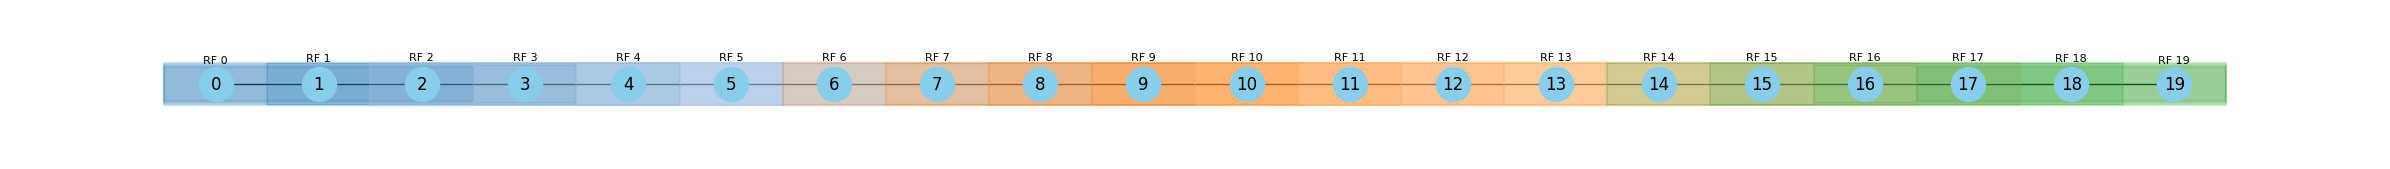

In [90]:
# plot a 1d chain to visualize the receptive field
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_1d_chain(L, receptive_field=None):
    G = nx.Graph()
    for i in range(L):
        G.add_node(i)
    for i in range(L - 1):
        G.add_edge(i + 1, i)

    pos = {i: (i, 0) for i in range(L)}

    fig, ax = plt.subplots(figsize=(1.2 * L, 1.8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=600, ax=ax)

    if receptive_field is not None:
        cmap = cm.get_cmap('tab20', L)
        norm = mcolors.Normalize(vmin=0, vmax=4*L)

        for i in range(L):
            neighbors = receptive_field[i]
            if not neighbors:
                continue
            min_x = min(neighbors)
            max_x = max(neighbors)
            width = max_x - min_x + 1

            height = 0.3 + 0.05 * len(neighbors)
            bottom = -height / 2  # center around y=0

            color = cmap(norm(i))
            rect = Rectangle(
                (min_x - 0.5, bottom),
                width, height,
                linewidth=2.5,
                edgecolor='black',
                facecolor=color,
                alpha=0.2,       # transparent fill
                linestyle='solid'
            )
            rect.set_facecolor(color)
            rect.set_edgecolor(color)
            rect.set_linewidth(1.5)
            rect.set_linestyle("solid")
            ax.add_patch(rect)
            ax.text(i, bottom + height + 0.05, f"RF {i}", ha='center', fontsize=8)

    ax.set_ylim(-1, 1)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_1d_chain(L, model.receptive_field)

In [4]:
import os
os.environ["NUMBA_NUM_THREADS"] = "20"

import netket as nk
import netket.experimental as nkx
import netket.nn as nknn
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

from math import pi
import numpy as np
from vmc_torch.fermion_utils import generate_random_fmps
import quimb.tensor as qtn
import symmray as sr

# Define the number of nodes
L = 6  # Replace with your desired number of nodes
spinless = False
cyclic = False
seed = 2
np.random.seed(seed)
# Generate all possible edges for a fully connected graph
edges = [(i, j) for i in range(L) for j in range(i + 1, L)]
# edges = qtn.edges_1d_chain(L, cyclic=cyclic)

# Create the fully connected graph
graph = nk.graph.Graph(edges=edges)
N = graph.n_nodes
# Display information about the graph
print(f"Number of nodes: {graph.n_nodes}")
print(f"Number of edges: {graph.n_edges}")

# Define the fermion filling and the Hilbert space
N_f = int(L)
n_fermions_per_spin = (N_f//2, N_f//2)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=n_fermions_per_spin)

# Define the random hopping fully connected Hubbard model Hamiltonian
U = 8.0
t_mean = 0.0
t_std = 1.0
mu = 0.0
# Generate edge-hopping dictionary
edge_to_hopping = {}
for (i,j) in graph.edges():
    t = np.random.normal(t_mean, t_std)
    edge_to_hopping[(i,j)] = t

H = 0.0
for (i,j) in graph.edges():
    t = edge_to_hopping[(i,j)]
    for spin in (1,-1):
        H -= t * (cdag(hi,i,spin) * c(hi,j,spin) + cdag(hi,j,spin) * c(hi,i,spin))
for i in graph.nodes():
    H += U * nc(hi,i,+1) * nc(hi,i,-1)

# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs/N)
print("Exact ground state energy:", E_gs)

Number of nodes: 6
Number of edges: 15
Exact ground state energy per site: -1.0403634742450327
Exact ground state energy: -6.242180845470196


In [ ]:
# fMPS spinful
D = 4
symmetry = 'U1'
seed = 2
# SU in quimb
fmps, charge_config = generate_random_fmps(L, D, seed, symmetry, Nf=N_f, cyclic=cyclic, spinless=spinless)
try:
    parse_edges_to_site_info = sr.utils.parse_edges_to_site_info
except AttributeError:
    parse_edges_to_site_info = sr.parse_edges_to_site_info

site_info = parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2 if spinless else 4,
    site_ind_id="k{}",
    site_tag_id="I{}",
)

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb), t in edge_to_hopping.items()
}

ham = qtn.LocalHam1D(L=L, H2=terms, cyclic=cyclic)
# su = qtn.SimpleUpdateGen(fmps, ham, compute_energy_per_site=True, D=D, gate_opts={'cutoff':1e-12})

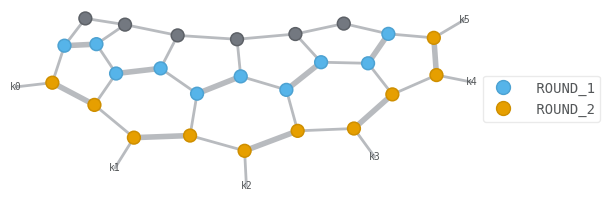

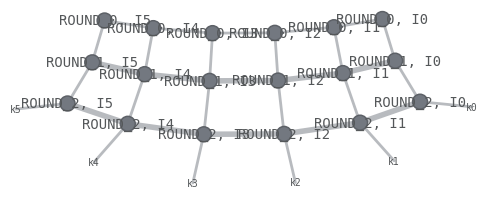

fMPS(tensors=18, indices=33, L=6, max_bond=16)

In [ ]:
from vmc_torch.fermion_utils import fMPS_TNF
def form_gated_fmps_tnf(
        fmps, 
        ham, 
        depth, 
        nn_where_list=None,
        x_tag_id="ROUND_{}",
        y_tag_id="I{}",
        site_tag_id="I{},{}",
    ):
    fmps1 = fmps.copy()

    if isinstance(nn_where_list, list):
        pass
    else:
        Warning("nn_where_list is not a list, using all nearest neighbor terms in the Hamiltonian")
        nn_where_list = [(i, i+1) for i in range(fmps.L-1)]
    
    for ts in fmps1.tensors:
        ts.modify(tags=['ROUND_0']+list(ts.tags))
    
    for i in range(depth):
        for where in nn_where_list:
            gate = ham.get_gate_expm(where, -0.5)
            site_inds = [fmps1.site_ind_id.format(site) for site in where]
            extra_tags = ['ROUND_{}'.format(i+1)]
            ltag = fmps1.site_tag_id.format(where[0])
            rtag = fmps1.site_tag_id.format(where[1])
            fmps1 = fmps1.gate_inds(gate, inds=site_inds, contract='split-gate', tags=extra_tags, ltags=ltag, rtags=rtag)
            
    for i in range(1,depth+1):
        for site in fmps1.sites:
            fmps1.contract_tags_([fmps1.site_tag_id.format(site), f'ROUND_{i}'], inplace=True, which='all')
    
    for x in range(0,depth+1):
        for y in range(L):
            ts = fmps1[[x_tag_id.format(x), y_tag_id.format(y)]]
            ts.add_tag(site_tag_id.format(x,y))
    
    fmps1 = fMPS_TNF.from_TN(fmps1)
    fmps1.set_Lx(depth+1)
    fmps1.set_Ly(fmps1.L)

    return fmps1

depth = 2
nn_where_list = [(i, i+1) for i in range(L-1)]
# nn_where_list = [where for where in ham.terms.keys()]
fmps1 = fmps.copy()
for ts in fmps1.tensors:
    ts.modify(tags=['ROUND_0']+list(ts.tags))

for i in range(depth):
    for where in nn_where_list:
        gate = ham.get_gate_expm(where, -0.5)
        site_inds = [fmps1.site_ind_id.format(site) for site in where]
        extra_tags = ['ROUND_{}'.format(i+1)]
        ltag = fmps1.site_tag_id.format(where[0])
        rtag = fmps1.site_tag_id.format(where[1])
        fmps1 = fmps1.gate_inds(gate, inds=site_inds, contract='split-gate', tags=extra_tags, ltags=ltag, rtags=rtag)
        
fmps1.draw(show_tags=False, color=['ROUND_1', 'ROUND_2'])
# contract each layer gates to a MPO
for i in range(1,depth+1):
    for site in fmps1.sites:
        fmps1.contract_tags_([fmps1.site_tag_id.format(site), f'ROUND_{i}'], inplace=True, which='all')

fmps1.draw()
fmps1

In [7]:
from vmc_torch.experiment.tn_model import fMPS_TNFModel
from vmc_torch.hamiltonian import spinful_random_Hubbard_chain
from vmc_torch.fermion_utils import fMPS_TNF
import torch
dtype = torch.float64
scale = 1.1

x_tag_id="ROUND_{}"
y_tag_id="I{}"
site_tag_id="I{},{}"
for x in range(0,depth+1):
    for y in range(L):
        ts = fmps1[[x_tag_id.format(x), y_tag_id.format(y)]]
        ts.add_tag(site_tag_id.format(x,y))
fmps1 = fMPS_TNF.from_TN(fmps1)
fmps1.set_Lx(depth+1)
fmps1.set_Ly(L)
fmps1.apply_to_arrays(lambda x: torch.tensor(scale*x, dtype=dtype))

In [8]:
# Hamiltonian parameters
symmetry = 'U1'
max_bond = 4
U = 8.0
N_f = int(L)
n_fermions_per_spin = (N_f//2, N_f//2)
t_mean = 0.0
t_std = 1.0
seed = 4
H = spinful_random_Hubbard_chain(L, t_mean, t_std, U, N_f, n_fermions_per_spin=n_fermions_per_spin, seed=seed)
graph = H.graph
# TN parameters
D = 4
chi = -2
dtype=torch.float64
random_config = torch.tensor(H.hilbert.random_state(seed), dtype=dtype)
# fmps1.get_amp(random_config, conj=True)
# product_state = fmps1.product_bra_state(random_config)
# tn = fmps1|product_state
# for ind in fmps1.site_inds:
#     tn.contract_ind(ind)
model = fMPS_TNFModel(fmps1, dtype=dtype, max_bond=4)
model(random_config)
# params, skeleton = qtn.pack(fmps1)

# qtn.unpack(params, skeleton)
# skeleton.set_params(params)
# skeleton = fmps1.copy()
# fMPS_TNF(fmps1).Lx

tensor([0.0035], dtype=torch.float64, grad_fn=<StackBackward0>)